## PCA

1. Get SVD of X
2. Project X onto k = 5, 10, 15, ... dimensions
3. For each k-dimensional approximation of X, calculate least squares weights
4. Using LS weights, calculate predicted y_hat
5. Compare MSE between y and y_hat

In [9]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Import data
FINAL_DATA = os.path.join('..', 'data', 'final')
x_df = pd.read_csv(os.path.join(FINAL_DATA, 'features.csv'),
                   header=None)
x_df = x_df.to_numpy()
x_df.shape

(10000, 26023)

In [10]:
x_df

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 35.51132582],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 15.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 14.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 43.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 75.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 52.        ]])

In [11]:
y_df = pd.read_csv(os.path.join(FINAL_DATA, 'labels.csv'),
                   header=None)
y_df = y_df.to_numpy()

In [12]:
y_df

array([[87],
       [87],
       [87],
       ...,
       [89],
       [91],
       [91]])

In [3]:
# # Calculate SVD of X
# u, sigma, vt = np.linalg.svd(x_df)

# # Save results
# PCA_PATH = os.path.join('..', 'data', 'pca_output')
# np.savetxt(os.path.join(PCA_PATH, 'u.csv'), u, delimiter=',')
# np.savetxt(os.path.join(PCA_PATH, 'sigma.csv'), sigma, delimiter=',')
# np.savetxt(os.path.join(PCA_PATH, 'vt.csv'), vt, delimiter=',')

# Load results
PCA_PATH = os.path.join('..', 'data', 'pca_output')
u = pd.read_csv(os.path.join(PCA_PATH, 'u.csv'), header=None).to_numpy()
sigma = pd.read_csv(os.path.join(PCA_PATH, 'sigma.csv'), header=None).to_numpy()
vt = pd.read_csv(os.path.join(PCA_PATH, 'vt.csv'), header=None).to_numpy()

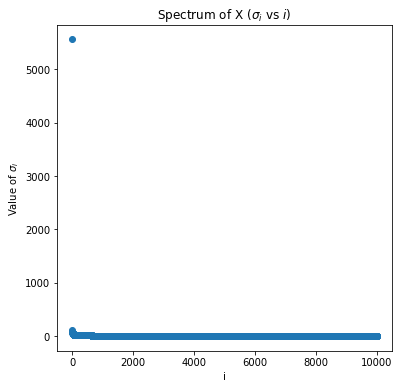

In [4]:
# Plot spectrum of x
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111) 
ax.scatter(range(len(sigma)), sigma)
ax.set_title('Spectrum of X ($\sigma_i$ vs $i$)')
ax.set_xlabel('i')
ax.set_ylabel('Value of $\sigma_i$')
plt.savefig(os.path.join('..', 'images', 'pca_spectrum.png'))
plt.show()

In [7]:
# Using pseudoinverse of X when p >> n
def get_ls_w(x, y):
    
    # Calculate SVD of x
    u, sigma, vt = np.linalg.svd(x)
    
    # Calculate pseudoinverse of sigma
    k = x.shape[1]
    sigma_psinv = np.zeros((vt.shape[0], u.shape[0])) 
    sigma_psinv[:k, :k] = np.diag(1 / sigma[:k])
    
    # Calculate least squares weights
    w = np.linalg.multi_dot([
        vt.T, sigma_psinv, u.T, y
    ])
    
    return w    

In [20]:
# Loop over different values of k
k_vals = [1, 2,3, 5, 10, 15, 20, 25, 50, 100]
mae_k = []
mse_k = []
results = pd.DataFrame()

for i in k_vals:
    
    print(f"Evaluating reconstruction using {i} components")
    
    # Project x onto i dimensions
    v = vt.T[:, 0:i]
    x_proj = np.matmul(x_df, v)
    
    # Learn least squares weights from projected X
    w_k = get_ls_w(x_proj, y_df)
    
    # Calculated predicted y and MSE
    y_hat = np.matmul(x_proj, w_k)
    mae = np.absolute(y_hat - y_df).mean()
    mse = ((y_hat - y_df) ** 2).mean()
    mae_k.append(mae)
    mse_k.append(mse)

    # Print results
    results = results.append({
        'num_components': i,
        'mse': mse
    }, ignore_index=True)

order = ['num_components', 'mse']
results = results[order]

Evaluating reconstruction using 1 components
Evaluating reconstruction using 2 components
Evaluating reconstruction using 3 components
Evaluating reconstruction using 5 components
Evaluating reconstruction using 10 components
Evaluating reconstruction using 15 components
Evaluating reconstruction using 20 components
Evaluating reconstruction using 25 components
Evaluating reconstruction using 50 components
Evaluating reconstruction using 100 components


In [21]:
RESULTS_PATH = os.path.join('..', 'data', 'results')
results.to_csv(os.path.join(RESULTS_PATH, 'pcr_results.csv'), index=False)

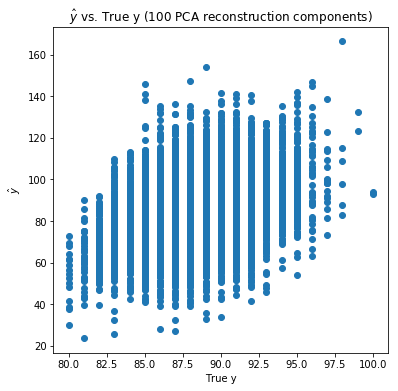

In [22]:
# Plot results
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111) 
ax.scatter(y_df, y_hat)
ax.set_title('$\hat{y}$ vs. True y (100 PCA reconstruction components)')
ax.set_xlabel('True y')
ax.set_ylabel('$\hat{y}$')
plt.savefig(os.path.join('..', 'images', 'pca_y_vs_yhat.png'))
plt.show()

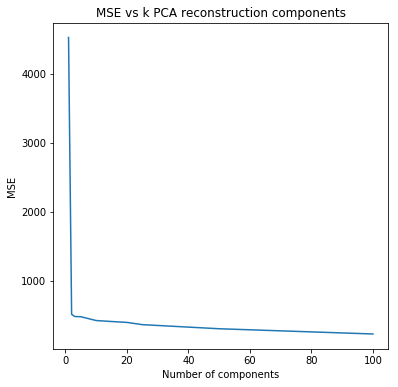

In [23]:
# Plot results
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111) 
ax.plot(k_vals, mse_k)
ax.set_title('MSE vs k PCA reconstruction components')
ax.set_xlabel('Number of components')
ax.set_ylabel('MSE')
plt.savefig(os.path.join('..', 'images', 'pca_mse_vs_k.png'))
plt.show()